# Summary

- [Carbon Emission Forecast](#carbon-emission-forecast)
    - [Imports](#imports)
    - [Emissions Data Reading](#emissions-data-reading)
    - [Auxiliary Functions](#auxiliary-functions)
    - [Grid Search](#grid-search)
    - [Forecast](#forecast)
    - [Export Values](#export-values)
- [Petrobras Emissions Data Analysis](#petrobras-emissions-data-analysis)
    - [Petrobras Data Reading](#petrobras-data-reading)
    - [Whole-History Fit](#whole-history-fit)
    - [Exponential Decay Fit](#exponential-decay-fit)
    - [Plotting](#plotting)
- [CECPI Index Time Series](#cecpi-index-time-series)

## Carbon Emission Forecast

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from scipy.optimize import curve_fit

import requests
from io import BytesIO

### Emissions Data Reading

In [2]:
URL = "https://raw.githubusercontent.com/thiagoneye/costcaster/main/data/Registro%20P%C3%BAblico%20de%20Emiss%C3%B5es.xlsx"
response = requests.get(URL)
df = pd.read_excel(BytesIO(response.content), engine="openpyxl")

# Data Processing

df = df[df["Escopo"] == "Escopo 1"]
df.drop(columns=["Setor da Indústria", "Escopo"], inplace=True)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:].reset_index()
df = df.rename(columns={"index": "Years"})
df.drop(columns=["CSN", "ISA Energia"], inplace=True)

# Company Names

dict_company_names = {
    "ArcelorMittal": "S-1",
    "Votorantim": "C-2",
    "Ternium": "S-2",
    "Suzano": "P-1",
    "Intercement": "C-1",
    "CBA": "A-1",
}

list_of_companies = list(dict_company_names.values())
df = df.rename(columns=dict_company_names)

# Dataframe Cleaning

for col in list_of_companies:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(float)

# Convert a Unit of Measurement

df.iloc[:, 1:] = df.iloc[:, 1:] / 1e6

# Domain Ranges

past_range = [2008, 2017]
commom_range = [2017, 2024]
future_range = [2025, 2031]

# Show Dataframe Informations

display(df)
display(df.info())

Empresa,Years,P-1,C-1,S-2,C-2,S-1,A-1
0,2008,0.767431,NaN,NaN,NaN,NaN,NaN
1,2009,0.722185,NaN,NaN,NaN,NaN,NaN
2,2010,0.772713,NaN,NaN,NaN,NaN,NaN
3,2011,1.008164,NaN,NaN,NaN,NaN,NaN
4,2012,0.908769,NaN,NaN,NaN,NaN,NaN
5,2013,0.826103,1.768296,9.211468,NaN,NaN,NaN
6,2014,1.113501,1.835637,9.800117,NaN,NaN,NaN
7,2015,1.596608,1.626257,9.995780,16.252087,NaN,NaN
8,2016,0.920025,1.258948,9.861517,13.300456,NaN,NaN
9,2017,0.864537,1.259595,10.765855,12.279286,18.439550,1.342764


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Years   17 non-null     int64  
 1   P-1     17 non-null     float64
 2   C-1     12 non-null     float64
 3   S-2     12 non-null     float64
 4   C-2     10 non-null     float64
 5   S-1     8 non-null      float64
 6   A-1     8 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 1.1 KB


None

### Auxiliary Functions

In [3]:
def applies_power_law(X, y, X_pred):
    X_last = X[-1]
    y_last = y[-1]
    y_pred = y_last * np.exp(np.log(0.91) * (X_pred - X_last) / (2030 - X_last))
    return y_pred


def applies_constant_line(y, X_pred):
    y_last = y[-1]
    y_pred = y_last * np.ones(len(X_pred))
    return y_pred


def get_values_from_dataframe(df, company_name):
    X = df.Years.values
    y = df.loc[:, company_name].values
    X = X[~np.isnan(y)]
    y = y[~np.isnan(y)]
    return X, y


def get_values(df, company_name, commom_range, future_range):
    """
    Return:
        X_hist: Historical X values
        y_hist: Historical y values
        X_filt: X values for the common domain
        y_filt: Y values for the common domain
        X_pred: Future X values
        X_plot: Future X values (starting in 2024)
    """
    X_hist, y_hist = get_values_from_dataframe(df, company_name)

    df_filt = df[df.Years >= commom_range[0]]
    X_filt, y_filt = get_values_from_dataframe(df_filt, company_name)

    X_pred = np.array(range(future_range[0], 2031))

    X_plot = np.insert(X_pred, 0, X_hist[-1])

    return (
        X_hist,
        y_hist,
        X_filt,
        y_filt,
        X_pred,
        X_plot,
    )


def set_weight_dict(function: str, weights):
    return {"function": function, "weights": weights}


def set_weights_sigmoid(data, common_range_delimiter=5, k=0.05):
    """Applies a sigmoid as weighting function for the weighted SVR."""

    t0 = common_range_delimiter
    weights = 1 / (1 + np.exp(-k * (data - t0)))

    return weights


def generate_weight_pairs_matrix(weight_a, weight_b, n):
    """Generate matrix with weight lists [wa, wb], such that wa + wb = 1 for tests."""

    # Matrix Columns
    col2 = np.linspace(weight_a, weight_b, n)
    col1 = 1 - col2

    # Matrix
    weight_pairs = np.column_stack((col1, col2))

    return weight_pairs


def fit_model(
    X,
    y,
    model: str,
    weighting_params: dict,
    commom_range_delimiter,
    C=10,
    epsilon=0.0001,
):
    """Select models for weighted regression.

    weighting_params: dict with keys
      - "function": "jump" | "sigmoid"
      - "weights":
              if "function" == "jump", must be a list of two floats: e.g. [0.1, 0.9],
                                       which will determine two constant weights
                                       for the past and common windows.
              if "function" == "sigmoid", must be a single float: e.g. k=0.01,
                                       which will control the sigmoid curve steep.

      For any model, the time t=t_b is the cutoff year that closes the past window
      and opens the common window, thus implying that this is the point where the
      weighting function should transition.
    """

    # Weighting
    if not all(key in weighting_params for key in ["function", "weights"]):
        raise ValueError("weighting_params must have keys 'function' and 'weights'.")

    if weighting_params["function"] == "sigmoid":
        weights = set_weights_sigmoid(
            y, commom_range_delimiter, weighting_params["weights"]
        )

    else:
        raise ValueError("Invalid weighting function. Must be 'jump' or 'sigmoid'.")

    # Reshape Input for 2D
    X = X.reshape(-1, 1)

    if model == "poly":
        M = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        M.fit(X, y, linearregression__sample_weight=weights)

    elif model == "svr-rbf":
        M = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10, epsilon=0.0001))
        M = SVR(kernel="rbf")
        M.fit(X, y, sample_weight=weights)

    elif model == "svr-poly":
        M = SVR(kernel="poly")
        M.fit(X, y, sample_weight=weights)

    elif model == "rf":
        M = RandomForestRegressor(n_estimators=100)
        M.fit(X, y, sample_weight=weights)

    return M


def add_axvspan_annotation(ax, ta, tb, y_baseline=None):
    """
    Adds an axvspan and an annotation with text based on tb.

    Parameters:
    ax: Matplotlib axis object.
    ta: Start of axvspan.
    tb: End of axvspan.
    y_baseline: Height of the annotation baseline (optional, defaults to the middle of the y-axis).

    Returns:
    None (adds axvspan and annotation to the axis).
    """

    if ta < 2017:
        text = "past"
        ax.axvspan(ta, tb, alpha=0.3, color="#e9ecef")
    elif ta == 2017:
        text = "common"
        ax.axvspan(ta, tb, alpha=0.3, color="#e7f5ff")
    else:
        text = "future"
        ax.axvspan(ta, tb, alpha=0.3, color="#ebfbee")  # ebdef0

    x_center = (ta + tb) / 2

    if y_baseline is None:
        y_min, y_max = ax.get_ylim()
        y_baseline = (y_min + y_max) / 2

    ax.annotate(
        text,
        xy=(x_center, y_baseline),
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round", facecolor="white", edgecolor="lightgray", alpha=0.8
        ),
    )


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)


def config_plot(ax, y_hist, x_lim, title, leg_loc="upper left", x_multiplelocator=2):
    y_min, y_max = min(y_hist), max(y_hist)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    y_baseline = np.mean([y_min, y_min_lim])
    ax.set_ylim([y_min_lim, y_max_lim])

    ax.xaxis.set_major_locator(MultipleLocator(x_multiplelocator))
    ax.set_xlim(x_lim)

    ax.grid(color="w", axis="y")
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc=leg_loc, fontsize="small")
    ax.set_title(title)

    return y_baseline

### Grid Search

In [4]:
results = []

for company_id, company_name in enumerate(list_of_companies):
    # Data Processing for Training
    data = get_values(df, company_name, commom_range, future_range)
    X_hist, y_hist, _, _, _, _ = data

    commom_range_delimiter = np.where(X_hist == commom_range[0])[0][0]

    best_score = np.inf  # negative if R2 or positive in other cases
    best_weight = None
    best_model = None

    for k in [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]:
        weighting_params = set_weight_dict("sigmoid", k)
        weights = set_weights_sigmoid(
            y_hist, commom_range_delimiter, weighting_params["weights"]
        )

        # Create pipeline with scaler and SVR
        pipeline = make_pipeline(
            StandardScaler(), SVR(kernel="rbf")  # or linear, poly, etc.
        )

        # Define o grid de parâmetros a testar
        param_grid = {
            "svr__C": [0.001, 0.01, 0.1, 1, 10, 100],  # Low C = more regularization
            "svr__epsilon": [
                0.0001,
                0.001,
                0.01,
                0.1,
                1,
                10,
                100,
            ],  # error tolerance range
        }

        # Create the GridSearchCV
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,  # 5-fold cross-validation
            scoring="neg_mean_absolute_error",  # or 'r2', 'neg_mean_absolute_error' 'neg_mean_squared_error' etc.
            n_jobs=-1,  # uses all CPU cores
        )

        # Executa o grid search
        grid_search.fit(X_hist.reshape(-1, 1), y_hist, svr__sample_weight=weights)

        mae = -grid_search.best_score_

        # Check if this was the best score
        if mae < best_score:  # > if R2 or < in other cases
            best_score = grid_search.best_score_
            best_weight = k
            best_c = grid_search.best_params_["svr__C"]
            best_e = grid_search.best_params_["svr__epsilon"]

    # Results
    results.append(
        [
            company_name,
            best_weight,
            best_c,
            best_e,
            best_score,
        ]
    )

best_param_by_company = dict()
best_param_by_company = {item[0]: item[1:] for item in results}

results = pd.DataFrame(
    results, columns=["company", "k", "svr_C", "svr_epsilon", "best_score"]
)

display(results)

/tmp/ipykernel_26653/4182481543.py:59: RuntimeWarning: overflow encountered in exp
  weights = 1 / (1 + np.exp(-k * (data - t0)))


,company,k,svr_C,svr_epsilon,best_score
0,S-1,0.01,100,1.0000,-1.882497
1,C-2,0.01,10,1.0000,-0.811835
2,S-2,0.01,1,0.0001,-0.397149
3,P-1,0.01,1,0.1000,-0.485532
4,C-1,0.01,10,0.0100,-0.129554
5,A-1,0.01,1,0.0100,-0.050001


### Forecast

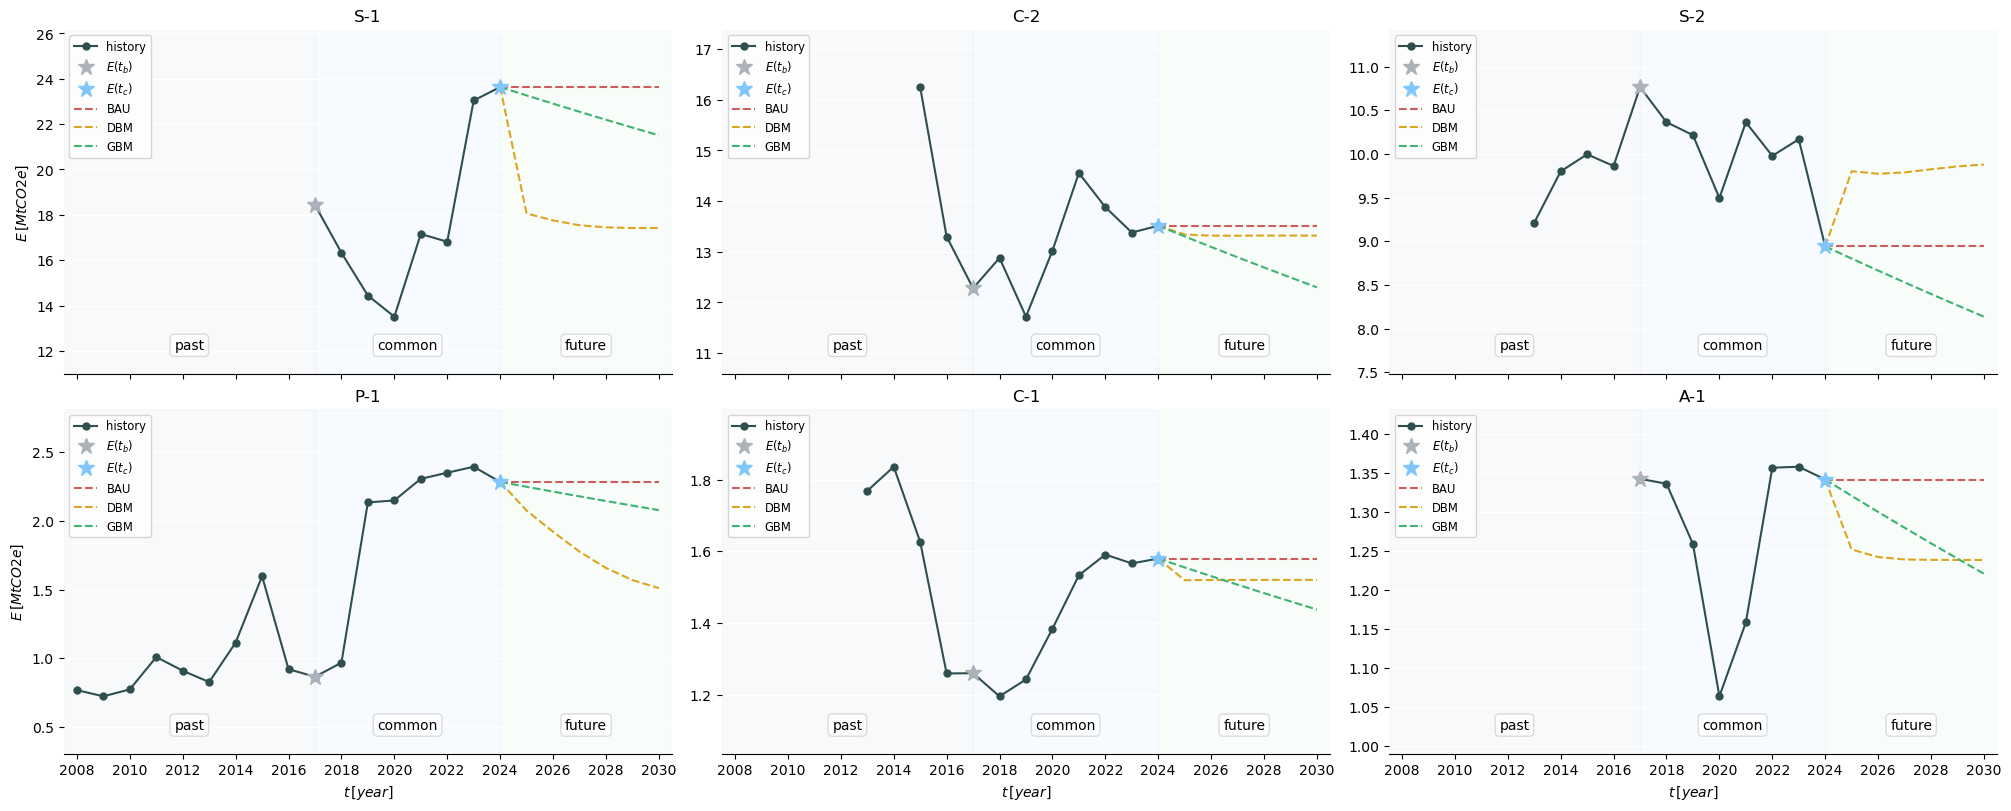

In [5]:
# Training Parameters (SVR)

k = 0.01
weighting_params = set_weight_dict("sigmoid", k)

# Preparing Variable for Data Export

output = dict()

# Plots

COLORS = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
    "Fit": mcolors.CSS4_COLORS["steelblue"],
    "Pred": mcolors.CSS4_COLORS["indigo"],
    0: ["#FF7F0E", "#FFB347", "#CC5500"],
    1: ["#8A2BE2", "#BA55D3"],
    2: ["#8B4513", "#8B4513"],
}

# Start Plot

fig, axs = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    # Data Processing for Training
    data = get_values(df, company_name, commom_range, future_range)
    X_hist, y_hist, X_filt, y_filt, X_pred, X_plot = data
    output["Years"] = X_pred.tolist()

    commom_range_delimiter = np.where(X_hist == commom_range[0])[0][0]

    # Plot (History)
    ax = axs[company_id]
    ax.plot(
        X_hist, y_hist, "-o", color=COLORS["History"], ms=5, label="history", zorder=10
    )
    ax.plot(
        X_filt[0], y_filt[0], "*", color="#abb2b9", ms=12, label="$E(t_b)$", zorder=11
    )
    ax.plot(
        X_hist[-1],
        y_hist[-1],
        "*",
        color="#80c6fa",
        ms=12,
        label="$E(t_c)$",
        zorder=12,
    )

    # BAU
    y_pred = applies_constant_line(y_hist, X_pred)
    y_plot = np.insert(y_pred, 0, y_hist[-1])
    output[f"{company_name} - BAU"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=COLORS["BAU"], label="BAU")

    # DBM
    y_pred = fit_model(
        X_hist,
        y_hist,
        "svr-rbf",
        weighting_params,
        commom_range_delimiter,
        C=best_param_by_company[company_name][1],
        epsilon=best_param_by_company[company_name][2],
    ).predict(X_pred.reshape(-1, 1))
    y_plot = np.insert(y_pred, 0, y_hist[-1])
    output[f"{company_name} - DBM"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=COLORS["DBM"], label="DBM")

    # GBM
    y_pred = applies_power_law(X_hist, y_hist, X_pred)
    y_plot = np.insert(y_pred, 0, y_hist[-1])
    output[f"{company_name} - GBM"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=COLORS["GBM"], label="GBM")

    # Configure Plot
    y_baseline = config_plot(
        ax,
        y_hist,
        x_lim=[past_range[0] - 0.5, future_range[1] - 0.5],
        title=f"{company_name}",
        leg_loc="upper left",
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$E \\, [MtCO2e]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

    if company_name == "S-2":
        y_min, y_max = min(y_pred), max(y_hist)
        y_min_lim, y_max_lim = get_ylim(y_min, y_max)
        y_baseline = np.mean([y_min, y_min_lim])
        ax.set_ylim([y_min_lim, y_max_lim])

    add_axvspan_annotation(
        ax, past_range[0] - 0.5, past_range[1], y_baseline=y_baseline
    )
    add_axvspan_annotation(ax, commom_range[0], commom_range[1], y_baseline=y_baseline)
    add_axvspan_annotation(
        ax, commom_range[1], future_range[1] - 0.5, y_baseline=y_baseline
    )

fig.savefig(f"../results/emissions/forecast.png", dpi=600, bbox_inches="tight")

### Export Values

In [6]:
e = pd.DataFrame(output)
e.to_excel("../data/Forecast (MtCO2e).xlsx")
display(e)

,Years,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
0,2025,23.632865,18.060261,23.264298,13.513428,13.340975,13.302679,8.940516,9.801581,8.801084,2.283988,2.074743,2.248368,1.579306,1.519020,1.554676,1.341908,1.252185,1.320980
1,2026,23.632865,17.756772,22.901478,13.513428,13.317894,13.095216,8.940516,9.772826,8.663826,2.283988,1.921093,2.213303,1.579306,1.519730,1.530430,1.341908,1.242492,1.300379
2,2027,23.632865,17.540634,22.544317,13.513428,13.317618,12.890989,8.940516,9.788235,8.528709,2.283988,1.776351,2.178785,1.579306,1.519925,1.506562,1.341908,1.239475,1.280099
3,2028,23.632865,17.448469,22.192726,13.513428,13.319519,12.689947,8.940516,9.823698,8.395699,2.283988,1.657053,2.144806,1.579306,1.519972,1.483066,1.341908,1.238880,1.260135
4,2029,23.632865,17.423024,21.846618,13.513428,13.319376,12.492040,8.940516,9.856964,8.264763,2.283988,1.569028,2.111357,1.579306,1.519983,1.459937,1.341908,1.238803,1.240482
5,2030,23.632865,17.418340,21.505907,13.513428,13.318683,12.297220,8.940516,9.878516,8.135870,2.283988,1.510201,2.078429,1.579306,1.519985,1.437168,1.341908,1.238796,1.221136


## Petrobras Emissions Data Analysis

### Petrobras Data Reading

In [7]:
URL = "https://raw.githubusercontent.com/thiagoneye/costcaster/main/data/Relat%C3%B3rio%20de%20Emiss%C3%B5es%20da%20Petrobras.xlsx"
response = requests.get(URL)
br = pd.read_excel(BytesIO(response.content), engine="openpyxl", skiprows=1)

# Last emissions only
E_last = df.iloc[-1]
E_last = E_last.to_dict()

# History
th, Eh = br["Ano"].values, br["milhões de toneladas"].values

### Whole-History Fit

- Best R2 score through polynomial fit for whole history data was found to be at maximum 5 degree (before poor conditioning) but 4-degree responds well

In [8]:
c = np.polyfit(th, Eh, deg=4)
poly = np.poly1d(c)
E_ = poly(th)
R2h = r2_score(Eh, E_)
print(f"R2 score (history fit) = {R2h:.2f}")

R2 score (history fit) = 0.77


### Exponential Decay Fit

- Notice that from 2014 onward, the emissions decreased monotonically
- Then, we'll use a exp decay fit to get the _mitigation rate_ only from the common window span for benchmarking purposes

In [9]:
# Common Window Start
tb = 2017


# Fit Model
def exp_decay(t, a, alpha):
    return a * np.exp(alpha * (t - tb))


# Common Window Span
cutoff = np.where(th == tb)[0].item()
th_e = th[cutoff:]
Eh_e = Eh[cutoff:]

# Fit
params, _ = curve_fit(exp_decay, th_e, Eh_e, method="lm")

# Mitigation Rate
ALPHA = params[1]

# Extract Fitted Parameters
print(f"Mitigation rate: {ALPHA:.3f}")

# Evaluate Fit
E_e = exp_decay(th_e, *params)
r2_e = r2_score(Eh_e, E_e)
print(f"R2 score (common window fit): {r2_e:.2f}")

Mitigation rate: -0.043
R2 score (common window fit): 0.73


In [10]:
# Inputs

tc = 2024  # Beginning of the Future Domain
tf = np.arange(tc, 2030 + 1)  # Future Domain

# Lambda Functions

# Decay Model (GBM)
f_k = lambda E_k, T, t: E_k * np.exp(np.log(0.91) / (2030 - T) * (t - T))
# Benchmark (Petrobras)
f_br = lambda E_k, T, t: E_k * np.exp(ALPHA * (t - T))

# Functions


def plot_future(ax, a, col, tf, Fk, Fbr, COLORS, comp, ALPHA):
    ax[a].plot(
        tf,
        Fk,
        c=COLORS[a][col],
        label=comp + f"($\\alpha$ = {np.log(0.91) / (2030 - 2024):.2f})",
    )
    ax[a].plot(
        tf,
        Fbr,
        c=COLORS[a][col],
        ls="--",
        label=comp + "($\\alpha_" + "{B}$ = " + f"{ALPHA:.2f})",
    )


def lag_cumulative(comp, br, opt, name):
    if opt == "cum":
        print(
            f"Cumulative emission lag ({name}) = {np.cumsum(comp)[-1] - np.cumsum(br)[-1]:.2f} tCO2e"
        )
        print(
            f"Emission surplus ({name}) = {(np.cumsum(comp)[-1] - np.cumsum(br)[-1])/np.cumsum(comp)[-1]*100:.2f}%"
        )
    elif opt == "2030":
        print(f"Emission lag only at 2030 = {comp[-1] - br[-1]:.3f} tCO2e\n")

### Plotting

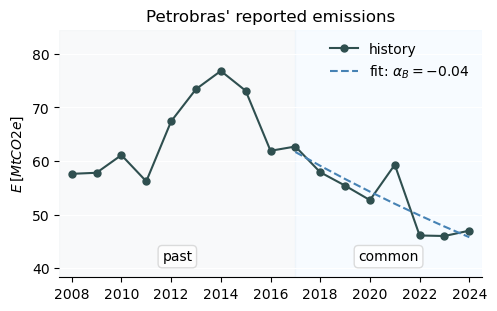

In [11]:
# Curve Fitting

fig, ax = plt.subplots(
    1, 1, figsize=(3 * 1.618, 3), sharey=False, constrained_layout=True
)

plt.plot(th, Eh, "-o", color=COLORS["History"], ms=5, label="history", zorder=2)
# plt.plot(th, E_, label="polyfit(4)", lw=0.75, ls=":", color="gray")
plt.plot(
    th_e,
    E_e,
    color=COLORS["Fit"],
    ls="--",
    label=f"fit: $\\alpha_B = {ALPHA:.2f}$",
)

y_baseline = config_plot(
    ax,
    Eh,
    x_lim=[min(th) - 0.5, commom_range[1] + 0.5],
    title="Petrobras' reported emissions",
    leg_loc="upper right",
)
# ax.set_xlabel("$t \\, [year]$")
ax.set_ylabel("$E \\, [MtCO2e]$")
plt.legend(frameon=False)

add_axvspan_annotation(ax, min(th) - 0.5, past_range[1], y_baseline=y_baseline)
add_axvspan_annotation(
    ax, commom_range[0], commom_range[1] + 0.5, y_baseline=y_baseline
)

fig.savefig(f"../results/emissions/mitigation-petrobras.png", dpi=600, bbox_inches="tight")

Cumulative emission lag (P-1) = 1.14 tCO2e
Emission surplus (P-1) = 7.46%
Cumulative emission lag (C-1) = 0.79 tCO2e
Emission surplus (C-1) = 7.46%
Cumulative emission lag (S-2) = 4.45 tCO2e
Emission surplus (S-2) = 7.46%
Cumulative emission lag (C-2) = 6.73 tCO2e
Emission surplus (C-2) = 7.46%
Cumulative emission lag (S-1) = 11.77 tCO2e
Emission surplus (S-1) = 7.46%
Emission lag only at 2030 = 3.203 tCO2e

Cumulative emission lag (A-1) = 0.67 tCO2e
Emission surplus (A-1) = 7.46%


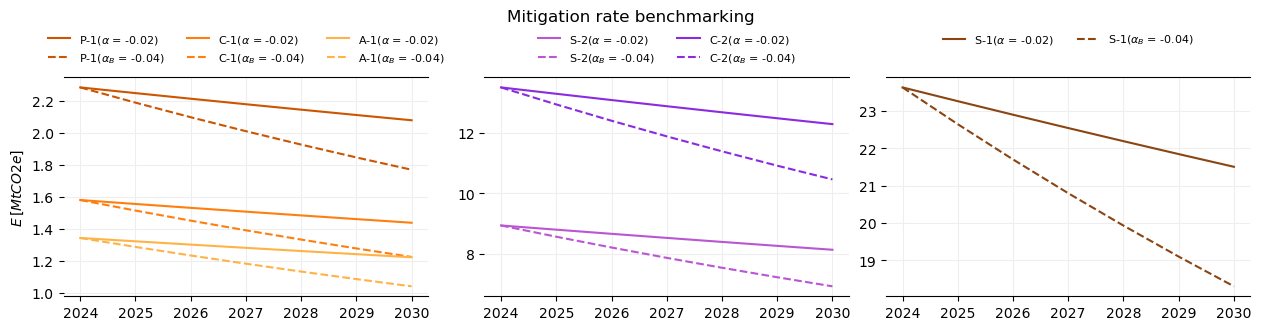

In [12]:
output_b = dict()
fig, ax = plt.subplots(1, 3, figsize=(12.5, 3), sharey=False, constrained_layout=True)
# ax = ax.flatten()

# Benchmark
for comp, E_k in E_last.items():
    Fk = f_k(E_k, tc, tf)
    Fbr = f_br(E_k, tc, tf)
    output_b[comp] = Fbr

    if comp in ["Years", "ISA Energia"]:
        continue

    elif comp == "C-1":
        plot_future(ax, 0, 0, tf, Fk, Fbr, COLORS, comp, ALPHA)
        lag_cumulative(Fk, Fbr, opt="cum", name=comp)

    elif comp == "A-1":
        plot_future(ax, 0, 1, tf, Fk, Fbr, COLORS, comp, ALPHA)
        lag_cumulative(Fk, Fbr, opt="cum", name=comp)

    elif comp == "P-1":
        plot_future(ax, 0, 2, tf, Fk, Fbr, COLORS, comp, ALPHA)
        lag_cumulative(Fk, Fbr, opt="cum", name=comp)

    elif comp == "C-2":
        plot_future(ax, 1, 0, tf, Fk, Fbr, COLORS, comp, ALPHA)
        lag_cumulative(Fk, Fbr, opt="cum", name=comp)

    elif comp == "S-2":
        plot_future(ax, 1, 1, tf, Fk, Fbr, COLORS, comp, ALPHA)
        lag_cumulative(Fk, Fbr, opt="cum", name=comp)

    elif comp == "S-1":
        plot_future(ax, 2, 0, tf, Fk, Fbr, COLORS, comp, ALPHA)
        lag_cumulative(Fk, Fbr, opt="cum", name=comp)
        lag_cumulative(Fk, Fbr, opt="2030", name=comp)

# ax[0].xaxis.set_major_locator(MultipleLocator(2))
ax[0].set_title("")
ax[0].legend(
    ncols=3, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, 1.25), frameon=False
)
ax[0].set_ylabel("$E \\, [MtCO2e]$")

# ax[1].xaxis.set_major_locator(MultipleLocator(2))
ax[1].set_title("")
ax[1].legend(
    ncols=2, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, 1.25), frameon=False
)

# ax[2].xaxis.set_major_locator(MultipleLocator(2))
ax[2].set_title("")
ax[2].legend(
    ncols=2, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, 1.25), frameon=False
)

for i in range(3):
    ax[i].spines["left"].set_visible(False)
    # ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].grid(axis="both", color="#eeeeee")

# Set the Title
fig.suptitle("Mitigation rate benchmarking", fontsize=12, y=1.05)

# Save Figure
fig.savefig(f"../results/emissions/mitigation-benchmark.png", dpi=600, bbox_inches="tight")

In [13]:
e_b = pd.DataFrame(output_b)
e_b["Years"] = np.arange(2024, 2031)
display(e_b)

e_b.to_excel("../data/Forecast - Benchmark.xlsx")

,Years,P-1,C-1,S-2,C-2,S-1,A-1
0,2024,2.283988,1.579306,8.940516,13.513428,23.632865,1.341908
1,2025,2.188742,1.513447,8.567684,12.949899,22.647341,1.285949
2,2026,2.097468,1.450334,8.210399,12.409870,21.702915,1.232323
3,2027,2.010001,1.389853,7.868014,11.892361,20.797873,1.180933
4,2028,1.926181,1.331894,7.539907,11.396433,19.930572,1.131686
5,2029,1.845857,1.276352,7.225482,10.921185,19.099439,1.084494
6,2030,1.768882,1.223127,6.924169,10.465756,18.302966,1.039269
